# Introduction

**Resources**

* [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) (2015) by Alec Radford, Luke Metz, Soumith Chintala
* [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167) (2015) by Sergey Ioffe, Christian Szegedy

Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage


In [5]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# MNIST Dataset

Load MNIST Dataset from Keras API. We only need train images, ignore labels and validation set.

In [3]:
(x_train_raw, _), (_, _) = tf.keras.datasets.mnist.load_data()

Convert to -1..1 range to mach tanh output from generator

In [4]:
x_train = (x_train_raw-127.5) / 127.5
x_train = x_train.reshape([len(x_train), -1])
print('x_train.shape:', x_train.shape)
print('x_train.min():', x_train.min())
print('x_train.max():', x_train.max())
print('x_train:\n', x_train)

x_train.shape: (60000, 784)
x_train.min(): -1.0
x_train.max(): 1.0
x_train:
 [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


# Celeb A

In [18]:
dataset_location = '../Datasets/img_align_celeba'

In [22]:
import os
import PIL

In [21]:
all_files = os.listdir(os.path.join(dataset_location, 'img_align_celeba'))

In [95]:
def crop_celeba(img, size):
    assert img.size == (178, 218)
    box = [25, 65, img.width-25, img.height-25]  # crop 25/65/25/25 from left/top/right/bottom
    return img.crop(box)                         # result.size = (128, 128)

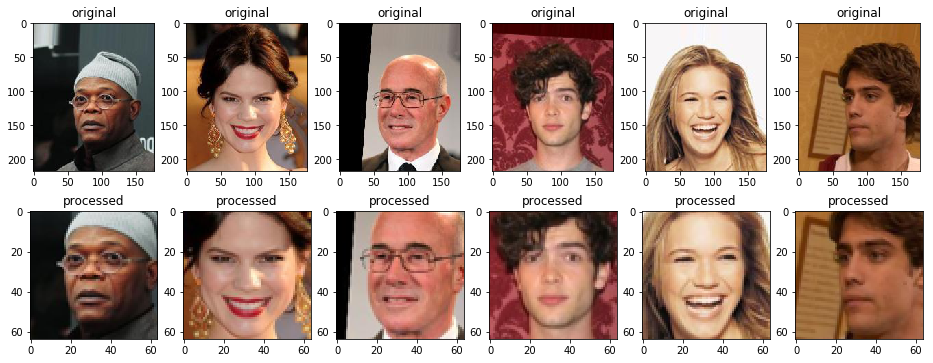

In [102]:
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=6, figsize=[16,6])
for i in range(len(axes1)):
    idx = np.random.randint(0, len(all_files))
    img_full_path = os.path.join(dataset_location, 'img_align_celeba', all_files[idx])
    img = PIL.Image.open(img_full_path)
    img_128x128 = crop_celeba(img, None)
    img_64x64 = img_128x128.resize([64, 64], PIL.Image.BICUBIC)
    axes1[i].imshow(img)
    axes1[i].set_title('original')
    axes2[i].imshow(img_64x64)
    axes2[i].set_title('processed')

In [106]:
all_images = []
for i in range(len(all_files)):
    img_full_path = os.path.join(dataset_location, 'img_align_celeba', all_files[i])
    img = PIL.Image.open(img_full_path)
    img = PIL.Image.open(img_full_path)
    img_128x128 = crop_celeba(img, None)
    img_64x64 = img_128x128.resize([64, 64], PIL.Image.BICUBIC)
    arr = np.array(img_64x64)
    assert arr.shape == (64, 64, 3)
    all_images.append(arr)
    if i % 10000 == 0:
        print(f'Image {i} of {len(all_files)}')
all_images = np.array(all_images)

Image 0 of 202599
Image 10000 of 202599
Image 20000 of 202599
Image 30000 of 202599
Image 40000 of 202599
Image 50000 of 202599
Image 60000 of 202599
Image 70000 of 202599
Image 80000 of 202599
Image 90000 of 202599
Image 100000 of 202599
Image 110000 of 202599
Image 120000 of 202599
Image 130000 of 202599
Image 140000 of 202599
Image 150000 of 202599
Image 160000 of 202599
Image 170000 of 202599
Image 180000 of 202599
Image 190000 of 202599
Image 200000 of 202599


In [114]:
all_images = np.array(all_images)

In [115]:
save_path = os.path.join(dataset_location, 'img_align_celeba.npz')
save_path

'../Datasets/img_align_celeba/img_align_celeba.npz'

In [116]:
np.savez(save_path, all_images=all_images)

# DCGAN in Keras

In [ ]:
from tensorflow.keras.layers import InputLayer, Dense                # InputLayer for pretier names in TensorBoard

generator = tf.keras.Sequential(name='Generator')
generator.add(InputLayer(input_shape=(100,), name='GenInput'))       # random noise input
generator.add(Dense(units=128, activation='elu', name='GenHidden'))  # one hidden layer
generator.add(Dense(784, activation='tanh', name='GenOutput'))       # MNIST-like output
# generator.compile(...)                                             # no need
generator.summary()

In [7]:
n_random = 100
n_channels = 1

In [17]:
from tensorflow.keras.layers import InputLayer, Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation

generator = tf.keras.Sequential()
generator.add(InputLayer(input_shape=(n_random,)))
generator.add(Dense(7*7*128, activation="relu"))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())

# generator.add(UpSampling2D())
# generator.add(Conv2D(128, kernel_size=3, padding="same"))
# generator.add(BatchNormalization(momentum=0.8))

# generator.add(Activation("relu"))
# generator.add(UpSampling2D())
# generator.add(Conv2D(64, kernel_size=3, padding="same"))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(Activation("relu"))
# generator.add(Conv2D(n_channels, kernel_size=3, padding="same"))
# generator.add(Activation("tanh"))

generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [12]:
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0         
__________

NameError: name 'Input' is not defined

In [128]:
28*28

784

In [127]:
dcgan = DCGAN(img_size=28, n_channels=1)

Discriminator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 8, 8, 64)          0     

# Reference

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [124]:
class DCGAN():
    def __init__(self, img_size, n_channels):
        # Input shape
        self.img_rows = img_size
        self.img_cols = img_size
        self.channels = n_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        print('Generator:')
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        print('Discriminator:')
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, save_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            self.discriminator.trainable = False
            g_loss = self.combined.train_on_batch(noise, valid)
            self.discriminator.trainable = True

            # Plot the progress
            if epoch % 50 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [119]:
# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

In [120]:
dcgan = DCGAN(img_size=28, n_channels=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

In [121]:
dcgan.train(X_train=X_train, epochs=4000, batch_size=32, save_interval=50)

0 [D loss: 1.038969, acc.: 35.94%] [G loss: 0.940512]
50 [D loss: 1.444660, acc.: 31.25%] [G loss: 1.801063]


KeyboardInterrupt: 